In [1]:
import os
import pandas as pd
import numpy as np
drive_dir = '/content/drive/MyDrive/AIRI/Datasets'
os.chdir(drive_dir)
print("Google Drive directory:", os.getcwd())

Google Drive directory: /content/drive/MyDrive/AIRI/Datasets


In [21]:
import numpy as np
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

class TimeSeriesBlockBootstrap:
    def __init__(self, returns: np.ndarray, stock_name: str, block_size: int = 10, seasonal_period: int = 252):
        self.returns = returns
        self.stock_name = stock_name
        self.block_size = block_size
        self.seasonal_period = seasonal_period
        self.prices = np.exp(np.cumsum(returns))
        self.original_prices = self.prices / self.prices[0]
        self._decompose()

    def _decompose(self):
        stl = STL(self.prices,
                  period=self.seasonal_period,
                  robust=True)
        result = stl.fit()

        self.trend = result.trend
        self.seasonal = result.seasonal
        self.remainder = result.resid

    def _generate_blocks(self, n_samples: int) -> np.ndarray:
        n_blocks = int(np.ceil(n_samples / self.block_size))
        max_start = len(self.remainder) - self.block_size
        start_points = np.random.randint(0, max_start, size=n_blocks)
        blocks = [self.remainder[start:start + self.block_size]
                 for start in start_points]
        return np.concatenate(blocks)[:n_samples]

    def generate_sample(self) -> np.ndarray:
        new_remainder = self._generate_blocks(len(self.returns))
        new_prices = self.trend + self.seasonal + new_remainder
        min_valid_price = 1e-10
        new_prices = np.maximum(new_prices, min_valid_price)
        new_returns = np.diff(np.log(new_prices))
        return np.concatenate(([0], new_returns))

    def generate_samples(self, n_samples: int = 100) -> np.ndarray:
        samples = np.zeros((n_samples, len(self.returns)))
        for i in range(n_samples):
            samples[i] = self.generate_sample()
        return samples

    def plot_bootstrap_analysis(self, n_samples: int = 100, n_paths: int = 20,
                              confidence_level: float = 0.90):
        samples = self.generate_samples(n_samples)
        price_paths = np.exp(np.cumsum(samples, axis=1))

        price_paths = price_paths / price_paths[:, 0:1]

        mean_path = np.mean(price_paths, axis=0)
        lower = np.percentile(price_paths, ((1 - confidence_level) / 2) * 100, axis=0)
        upper = np.percentile(price_paths, (1 - (1 - confidence_level) / 2) * 100, axis=0)

        plt.figure(figsize=(12, 6))

        plt.grid(True, linestyle=':', alpha=0.6)

        plt.fill_between(range(len(self.returns)), lower, upper,
                        color='gray', alpha=0.2,
                        label=f'{int(confidence_level*100)}% Confidence Interval')

        for i in range(min(n_paths, n_samples)):
            plt.plot(price_paths[i], color='blue', alpha=0.2, linewidth=0.5)

        plt.plot(self.original_prices, color='green', linewidth=1.5,
                label='Original Path')

        plt.plot(mean_path, color='red', linestyle='--', linewidth=1.5,
                label='Mean Path')

        plt.title(f'Bootstrapped Price Paths for {self.stock_name}')
        plt.xlabel('Days')
        plt.ylabel('Price')
        plt.legend(loc='upper right')

        buffer = 0.05
        y_min = min(lower.min(), self.original_prices.min())
        y_max = max(upper.max(), self.original_prices.max())
        plt.ylim(y_min - buffer * (y_max - y_min),
                y_max + buffer * (y_max - y_min))

        plt.tight_layout()
        plt.show()

In [13]:
import numpy as np
import pandas as pd
from scipy import stats
from typing import Union, Tuple
import matplotlib.pyplot as plt

class MultivariateGBMSimulator:
    def __init__(self, log_returns: pd.DataFrame, original_prices: pd.DataFrame = None):
        self.log_returns = log_returns
        self.original_prices = original_prices
        self.n_assets = log_returns.shape[1]
        self.asset_names = log_returns.columns
        self.analyze_historical_properties()

    def analyze_historical_properties(self):
        self.daily_mu = self.log_returns.mean()
        self.daily_sigma = self.log_returns.std()

        self.mu = self.daily_mu * len(self.log_returns)
        self.sigma = self.daily_sigma * np.sqrt(len(self.log_returns))

        self.skew = stats.skew(self.log_returns)
        self.kurtosis = stats.kurtosis(self.log_returns)

        self.correlation = self.log_returns.corr()
        self.covariance = self.log_returns.cov()

        self.vol_cluster = pd.Series(index=self.asset_names)
        for asset in self.asset_names:
            self.vol_cluster[asset] = np.corrcoef(
                np.abs(self.log_returns[asset][1:]),
                np.abs(self.log_returns[asset][:-1])
            )[0, 1]

    def _generate_correlated_normals(self, n_days: int) -> pd.DataFrame:
        Z = np.random.normal(size=(n_days, self.n_assets))
        L = np.linalg.cholesky(self.correlation)
        correlated_vars = Z @ L.T

        # Scale by volatility and add drift
        for i, asset in enumerate(self.asset_names):
            correlated_vars[:, i] = (correlated_vars[:, i] * self.daily_sigma[asset]
                                   + self.daily_mu[asset])

        return pd.DataFrame(correlated_vars, columns=self.asset_names)

    def _generate_correlated_johnson(self, n_days: int) -> pd.DataFrame:
      johnson_rvs = pd.DataFrame(index=range(n_days), columns=self.asset_names)
      for asset in self.asset_names:
          asset_returns = self.log_returns[asset]
          johnson_params = stats.johnsonsu.fit(asset_returns)
          rvs = stats.johnsonsu.rvs(*johnson_params, size=n_days)

          # Standardize and rescale to match original moments
          rvs = (rvs - np.mean(rvs)) / np.std(rvs)
          johnson_rvs[asset] = rvs * self.daily_sigma[asset] + self.daily_mu[asset]

      values = johnson_rvs.values

      uniform_scores = np.zeros_like(values)
      for j in range(values.shape[1]):
          uniform_scores[:, j] = stats.rankdata(values[:, j]) / (n_days + 1)
      normal_scores = stats.norm.ppf(uniform_scores)
      L = np.linalg.cholesky(self.correlation)
      correlated_scores = normal_scores @ L.T
      result = pd.DataFrame(index=range(n_days), columns=self.asset_names)
      for i, asset in enumerate(self.asset_names):
          ranks = stats.rankdata(correlated_scores[:, i])
          sorted_rvs = np.sort(johnson_rvs[asset].values)
          result[asset] = sorted_rvs[ranks.astype(int) - 1]

      return result

    def _add_volatility_clustering(self, returns: pd.DataFrame) -> pd.DataFrame:
        clustered_returns = returns.copy()

        for asset in self.asset_names:
            if abs(self.vol_cluster[asset]) > 0.1:
                abs_returns = np.abs(clustered_returns[asset].values)
                for i in range(1, len(returns)):
                    abs_returns[i] = (
                        abs_returns[i] * (1 - self.vol_cluster[asset]) +
                        abs_returns[i-1] * self.vol_cluster[asset]
                    )
                clustered_returns[asset] = (
                    np.sign(clustered_returns[asset]) * abs_returns
                )

        return clustered_returns

    def simulate_returns(self,
                        n_days: int,
                        preserve_moments: bool = True
                        ) -> pd.DataFrame:
        if preserve_moments:
            returns = self._generate_correlated_johnson(n_days)
        else:
            returns = self._generate_correlated_normals(n_days)

        returns = self._add_volatility_clustering(returns)
        return returns

    def returns_to_price_paths(self,
                             returns: pd.DataFrame,
                             initial_values: pd.Series = None
                             ) -> pd.DataFrame:
        if initial_values is None:
            initial_values = pd.Series(1.0, index=self.asset_names)

        log_prices = np.log(initial_values) + returns.cumsum()
        prices = np.exp(log_prices)
        return pd.concat([initial_values.to_frame().T, prices])

    def simulate_multiple_price_paths(self,
                                    n_paths: int,
                                    n_days: int,
                                    initial_values: pd.Series = None,
                                    preserve_moments: bool = True
                                    ) -> dict:
        if initial_values is None:
            initial_values = pd.Series(1.0, index=self.asset_names)

        paths = {asset: pd.DataFrame() for asset in self.asset_names}

        for i in range(n_paths):
            returns = self.simulate_returns(n_days, preserve_moments)
            prices = self.returns_to_price_paths(returns, initial_values)

            for asset in self.asset_names:
                paths[asset][f'path_{i}'] = prices[asset]

        return paths

    def plot_simulations(self,
                        n_paths: int,
                        n_days: int,
                        initial_values: pd.Series = None,
                        preserve_moments: bool = True):
        paths_dict = self.simulate_multiple_price_paths(
            n_paths, n_days, initial_values, preserve_moments
        )

        n_assets = len(self.asset_names)
        fig, axes = plt.subplots(n_assets, 1, figsize=(12, 6*n_assets))
        if n_assets == 1:
            axes = [axes]

        for ax, asset in zip(axes, self.asset_names):
            paths_df = paths_dict[asset]
            paths_df = paths_df.reset_index(drop=True)

            for i in range(min(50, n_paths)):
                ax.plot(paths_df[f'path_{i}'],
                       alpha=0.1,
                       color='blue')

            mean_path = paths_df.mean(axis=1)
            mean_path = mean_path.reset_index(drop=True)
            percentile_5 = paths_df.quantile(0.05, axis=1)
            percentile_95 = paths_df.quantile(0.95, axis=1)
            ax.plot(mean_path,
                   'r--',
                   label='Mean Path',
                   linewidth=2)

            ax.fill_between(paths_df.index,
                          percentile_5,
                          percentile_95,
                          color='gray',
                          alpha=0.2,
                          label='90% Confidence Interval')

            if self.original_prices is not None:
                original = self.original_prices[asset]
                if initial_values is not None:
                    scale_factor = initial_values[asset] / original.iloc[0]
                    original = original * scale_factor

                min_length = min(len(original), len(paths_df))
                ax.plot(original[:min_length],
                       'g-',
                       label='Original Path',
                       linewidth=2)

            ax.set_title(f'Simulated Price Paths for {asset}')
            ax.set_xlabel('Days')
            ax.set_ylabel('Price')
            ax.legend()
            ax.grid(True)

        plt.tight_layout()
        plt.show()

        return paths_dict

In [19]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import Dict, Tuple
import warnings

class BacktestEvaluator:
    def __init__(self, returns_df: pd.DataFrame):
        self.returns_df = returns_df
        self.asset_names = returns_df.columns
        self.n_assets = len(self.asset_names)

        self.prices_df = pd.DataFrame(
            np.exp(np.cumsum(returns_df, axis=0)),
            columns=self.asset_names,
            index=returns_df.index
        )

        print("Initializing GBM simulator...")
        self.gbm_simulator = MultivariateGBMSimulator(
            log_returns=returns_df,
            original_prices=self.prices_df
        )

        print("Initializing Bootstrap simulators...")
        self.bootstrap_simulators = {}
        for asset in tqdm(self.asset_names):
            asset_returns = returns_df[asset].values
            asset_returns = np.nan_to_num(asset_returns, nan=0.0)

            self.bootstrap_simulators[asset] = TimeSeriesBlockBootstrap(
                returns=asset_returns,
                stock_name=asset,
                block_size=max(5, len(asset_returns) // 50),
                seasonal_period=252
            )

    def generate_paths(self,
                      n_samples: int = 100,
                      n_days: int = None,
                      preserve_moments: bool = True
                      ) -> Tuple[Dict[str, pd.DataFrame], Dict[str, np.ndarray]]:

        if n_days is None:
            n_days = len(self.returns_df)

        print("Generating GBM paths...")
        gbm_paths = self.gbm_simulator.simulate_multiple_price_paths(
            n_paths=n_samples,
            n_days=n_days,
            preserve_moments=preserve_moments
        )

        print("Generating Bootstrap paths...")
        bootstrap_paths = {}

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            for asset in tqdm(self.asset_names, desc="Generating Bootstrap Paths"):
                samples = self.bootstrap_simulators[asset].generate_samples(n_samples)

                samples = np.clip(samples, -0.5, 0.5)

                price_paths = np.exp(np.cumsum(samples, axis=1))
                price_paths = price_paths / price_paths[:, 0:1]


                price_paths = np.nan_to_num(price_paths, nan=1.0, posinf=1.0, neginf=1.0)

                bootstrap_paths[asset] = pd.DataFrame(
                    price_paths.T,
                    columns=[f'path_{i}' for i in range(n_samples)]
                )

        return gbm_paths, bootstrap_paths

    def plot_comparison(self,
                       n_samples: int = 100,
                       n_paths_to_plot: int = 20,
                       n_days: int = None,
                       preserve_moments: bool = True):

        print("Generating paths for comparison...")
        gbm_paths, bootstrap_paths = self.generate_paths(
            n_samples=n_samples,
            n_days=n_days,
            preserve_moments=preserve_moments
        )

        print("\nPlotting GBM simulations...")
        self.gbm_simulator.plot_simulations(
            n_paths=n_paths_to_plot,
            n_days=n_days if n_days is not None else len(self.returns_df),
            preserve_moments=preserve_moments
        )

        print("\nPlotting Bootstrap simulations...")
        for asset in tqdm(self.asset_names, desc="Creating bootstrap plots"):
            self.bootstrap_simulators[asset].plot_bootstrap_analysis(
                n_samples=n_samples,
                n_paths=n_paths_to_plot,
                confidence_level=0.90
            )

        return gbm_paths, bootstrap_paths

In [15]:
sp = pd.read_csv('sp500_returns.csv')

In [16]:
stocks = ['MMM', 'FAST', 'ROL', 'CMCSA', 'MHK', 'ADP']
returns = sp[stocks].dropna()

In [17]:
returns

,MMM,FAST,ROL,CMCSA,MHK,ADP
1,-0.040378,-0.056089,-0.015748,-0.077718,-0.023065,0.000000
2,0.028127,0.043894,0.000000,-0.026642,0.018167,-0.009856
3,0.077551,0.000000,0.000000,0.038259,-0.005333,0.013120
4,0.019765,-0.006154,0.015748,-0.032277,0.012671,0.022554
5,-0.005139,-0.025001,0.015504,0.120651,0.007688,0.024391
...,...,...,...,...,...,...
6243,-0.013686,0.008208,0.001294,0.000240,-0.148744,-0.005092
6244,0.043446,0.010753,0.015401,0.004311,0.006322,-0.005292
6245,-0.007824,0.012186,0.001273,0.005482,0.005301,0.005258
6246,-0.013308,0.009362,-0.010871,0.004033,0.021517,0.016635


Initializing GBM simulator...
Initializing Bootstrap simulators...


100%|██████████| 6/6 [01:10<00:00, 11.73s/it]


Generating paths for comparison...
Generating GBM paths...
Generating Bootstrap paths...


Generating Bootstrap Paths: 100%|██████████| 6/6 [00:00<00:00, 700.39it/s]


Plotting GBM simulations...


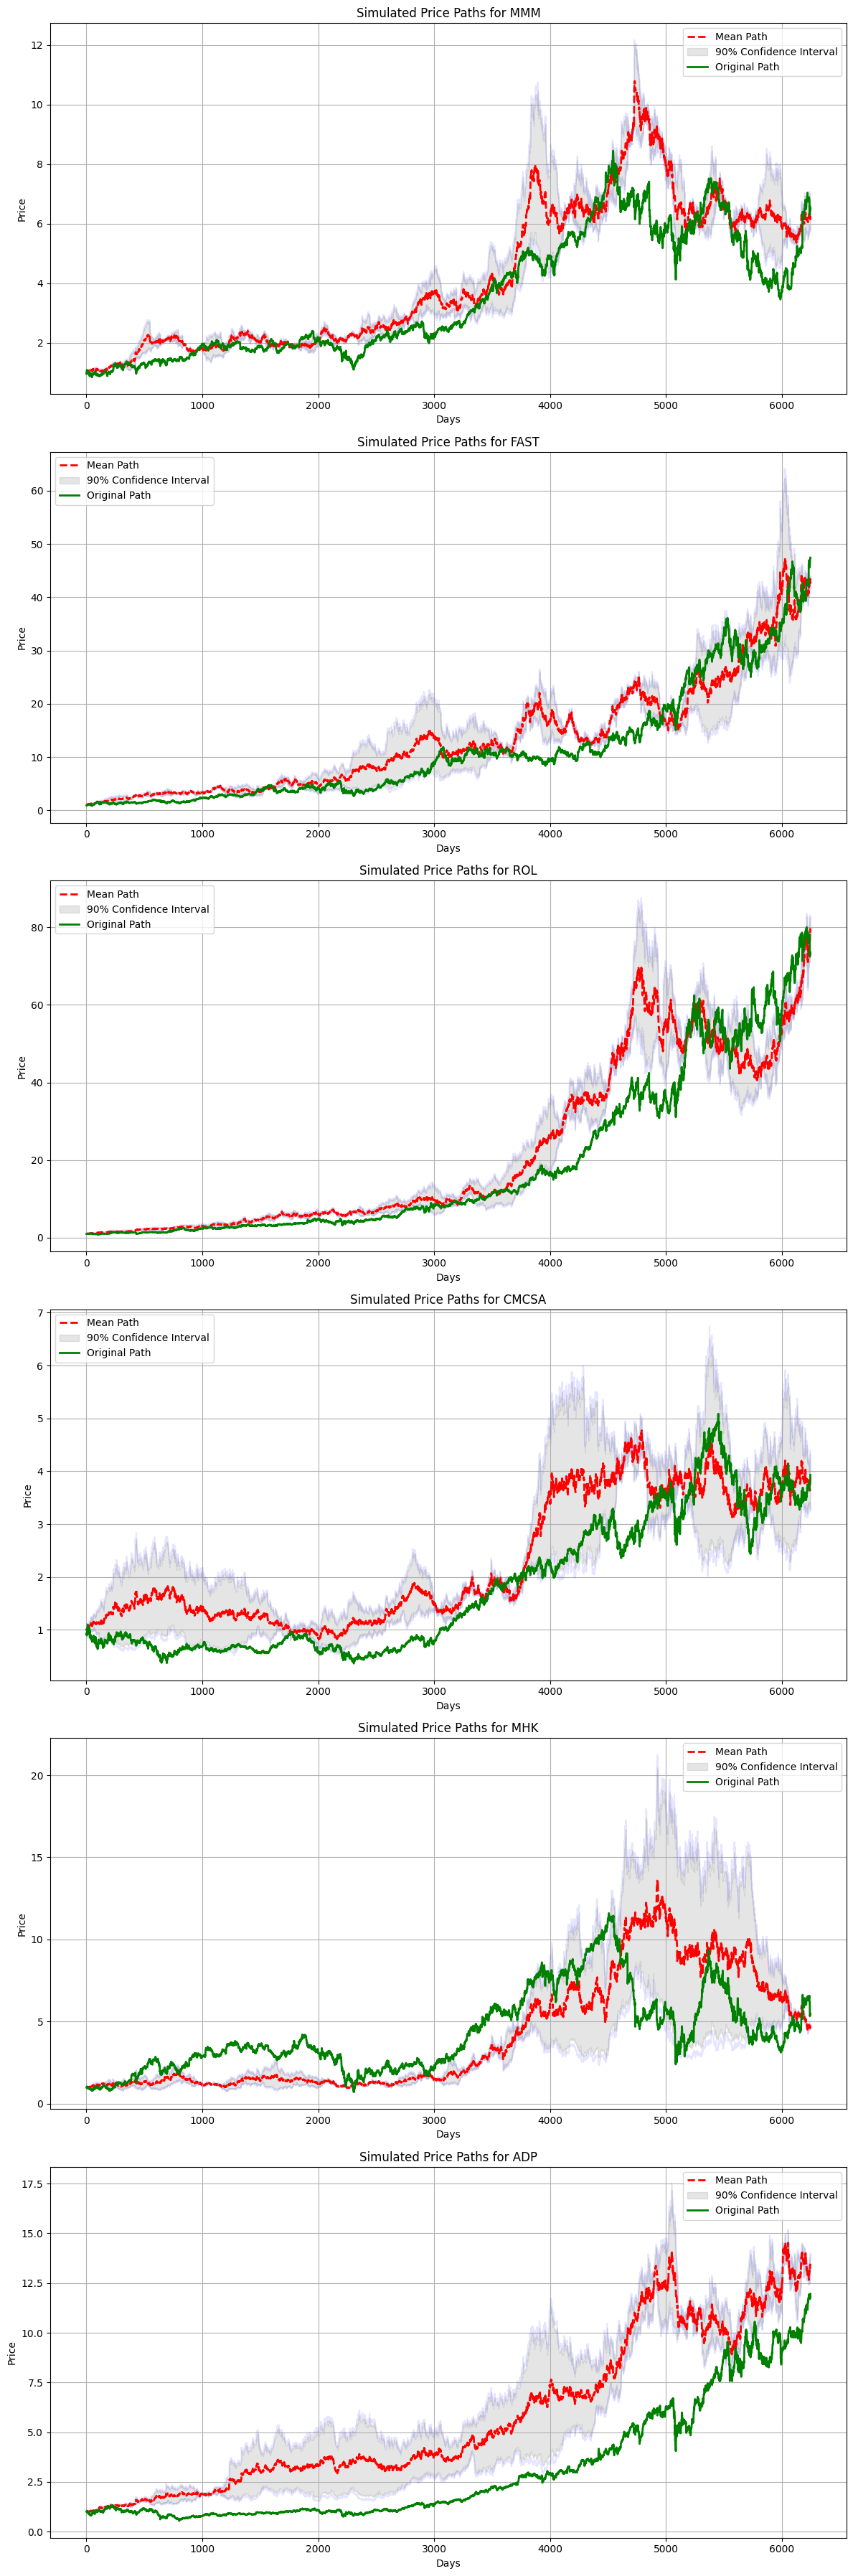


Plotting Bootstrap simulations...


Creating bootstrap plots:   0%|          | 0/6 [00:00<?, ?it/s]

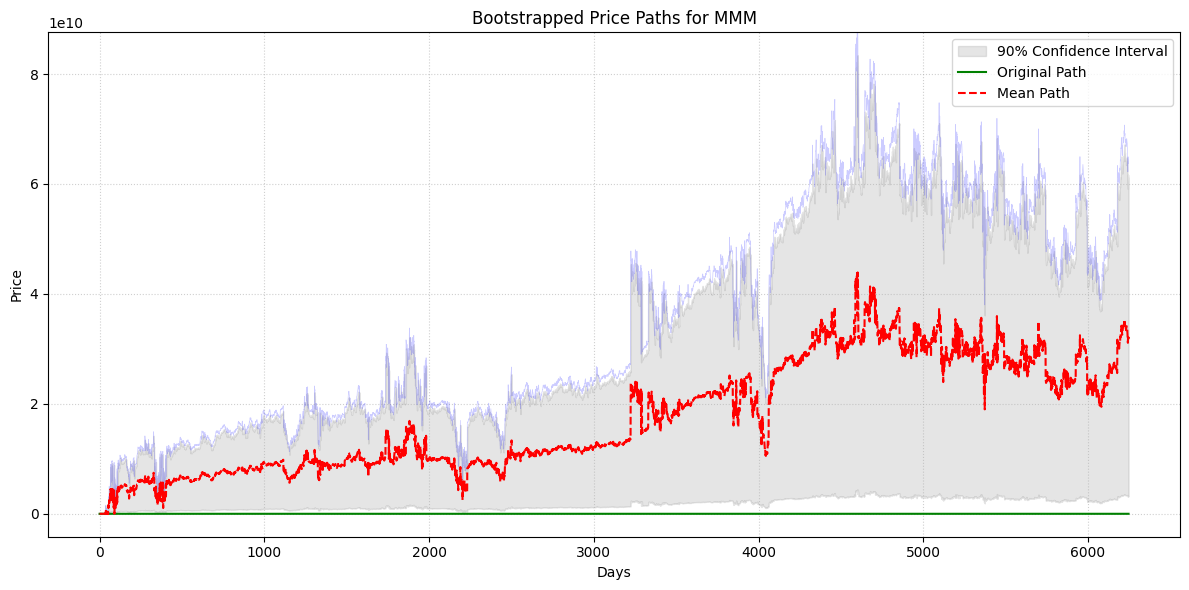

Creating bootstrap plots:  17%|█▋        | 1/6 [00:00<00:02,  1.84it/s]

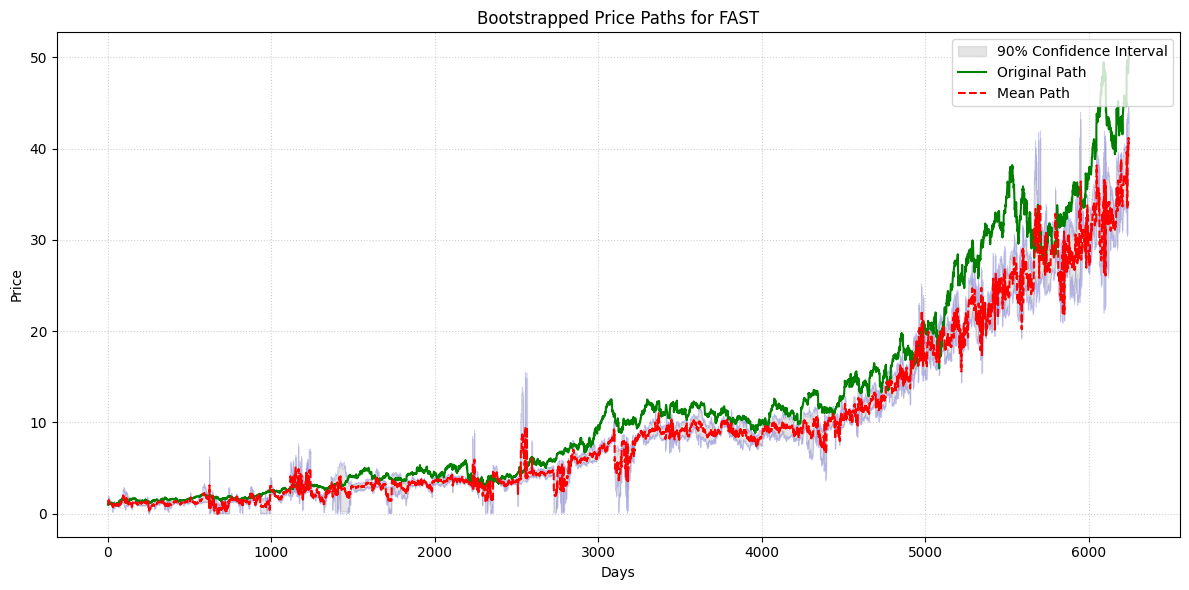

Creating bootstrap plots:  33%|███▎      | 2/6 [00:00<00:01,  2.18it/s]

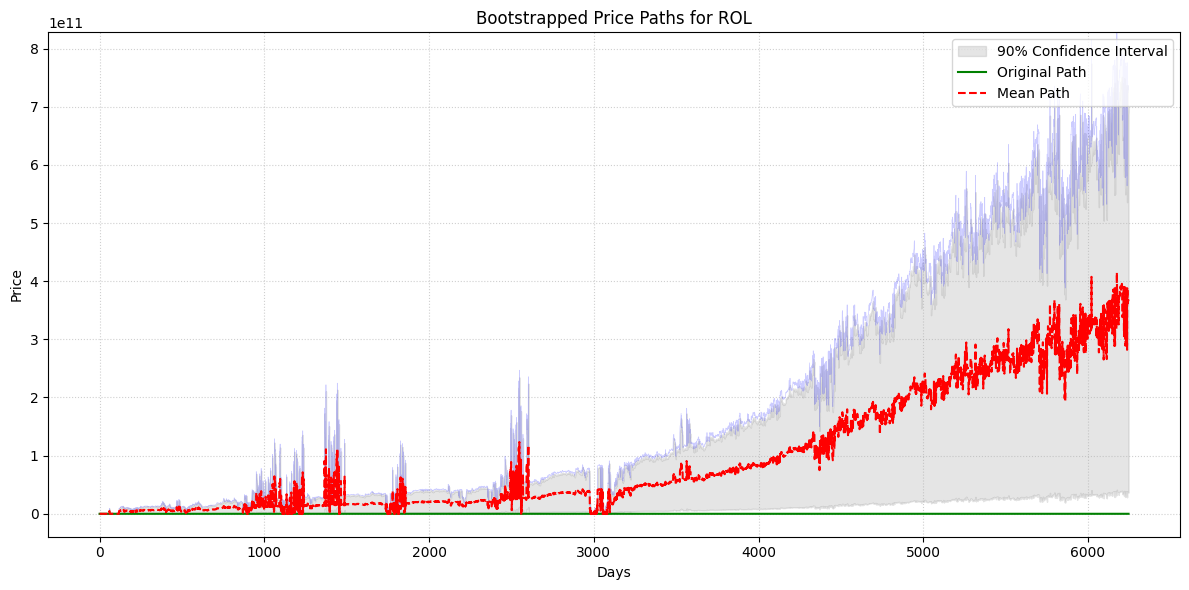

Creating bootstrap plots:  50%|█████     | 3/6 [00:01<00:01,  2.17it/s]

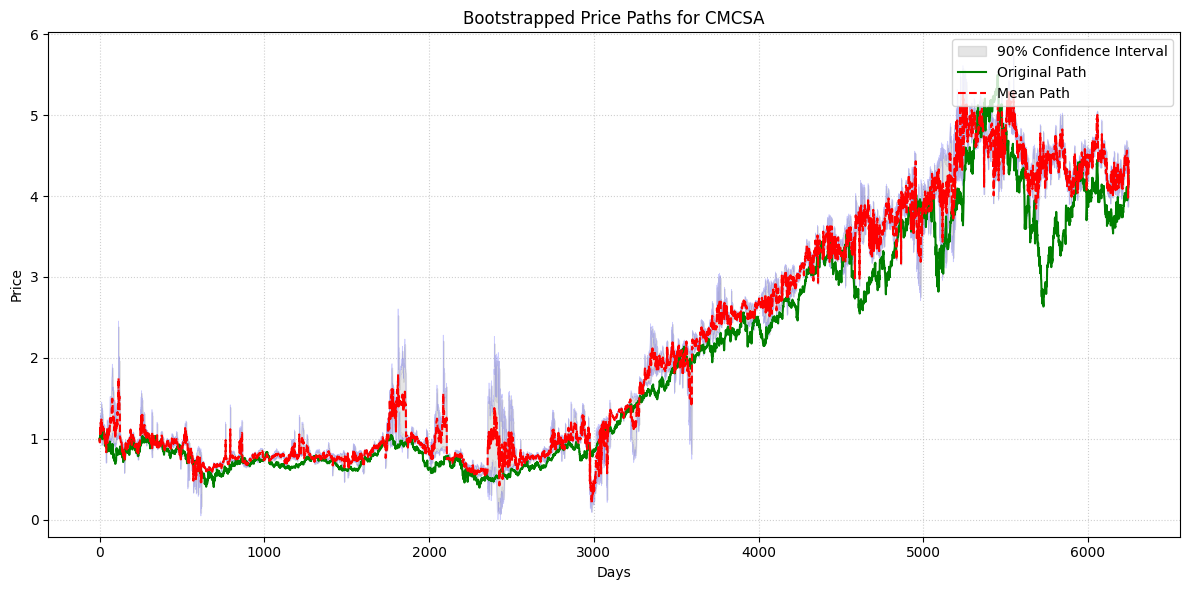

Creating bootstrap plots:  67%|██████▋   | 4/6 [00:01<00:00,  2.21it/s]

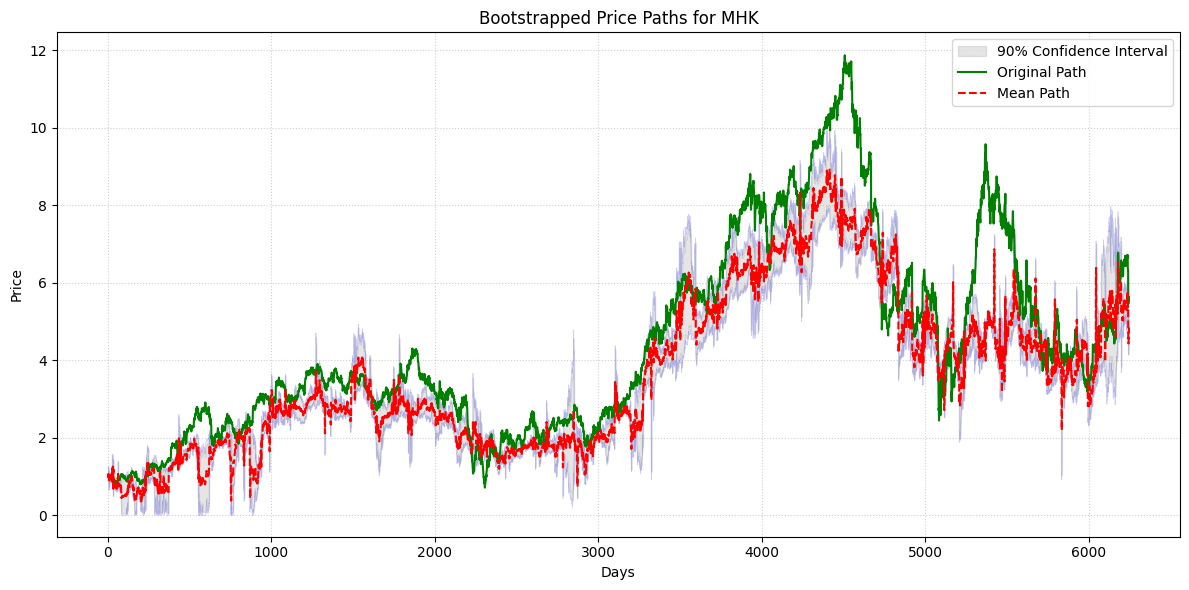

Creating bootstrap plots:  83%|████████▎ | 5/6 [00:02<00:00,  2.26it/s]

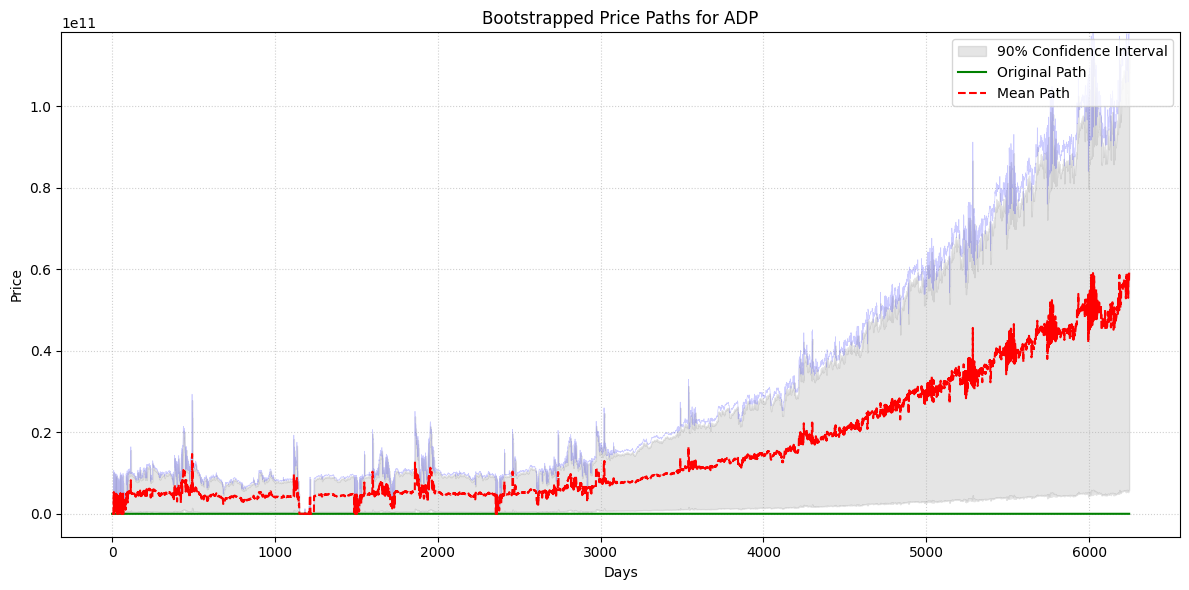

Creating bootstrap plots: 100%|██████████| 6/6 [00:02<00:00,  2.21it/s]


In [22]:
evaluator = BacktestEvaluator(returns)

#gbm_paths, bootstrap_paths = evaluator.generate_paths(n_samples=10)

gbm_paths, bootstrap_paths = evaluator.plot_comparison(
    n_samples=2,
    n_paths_to_plot=2
)